# Out-of-sample forecasting experiments

We conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, we evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 topics most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). We forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 topics (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11591
EM iteration 50, llf=-11393, convergence criterion=1.4221e-06
EM converged at iteration 60, llf=-11393, convergence criterion=9.8574e-07 < tolerance=1e-06
EM start iterations, llf=-11603
EM iteration 50, llf=-11405, convergence criterion=1.4217e-06
EM converged at iteration 60, llf=-11404, convergence criterion=9.8546e-07 < tolerance=1e-06
EM start iterations, llf=-11656
EM iteration 50, llf=-11454, convergence criterion=1.4259e-06
EM converged at iteration 60, llf=-11454, convergence criterion=9.883e-07 < tolerance=1e-06
EM start iterations, llf=-11664
EM iteration 50, llf=-11463, convergence criterion=1.4213e-06
EM converged at iteration 60, llf=-11463, convergence criterion=9.856e-07 < tolerance=1e-06
EM start iterations, llf=-11727
EM iteration 50, llf=-11524, convergence criterion=1.4322e-06
EM converged at iteration 60, llf=-11524, convergence criterion=9.9309e-07 < tolerance=1e-06
EM start iterations, llf=-11736
EM iteration 50, llf=-11533, conver

EM converged at iteration 33, llf=-12717, convergence criterion=9.8871e-07 < tolerance=1e-06
EM start iterations, llf=-12948
EM converged at iteration 33, llf=-12766, convergence criterion=9.8542e-07 < tolerance=1e-06
EM start iterations, llf=-12958
EM converged at iteration 34, llf=-12776, convergence criterion=9.6715e-07 < tolerance=1e-06
EM start iterations, llf=-13005
EM converged at iteration 34, llf=-12824, convergence criterion=9.6922e-07 < tolerance=1e-06
EM start iterations, llf=-13058
EM converged at iteration 33, llf=-12875, convergence criterion=9.8452e-07 < tolerance=1e-06
EM start iterations, llf=-13108
EM converged at iteration 33, llf=-12924, convergence criterion=9.7361e-07 < tolerance=1e-06
EM start iterations, llf=-13108
EM converged at iteration 33, llf=-12924, convergence criterion=9.7361e-07 < tolerance=1e-06
EM start iterations, llf=-13116
EM converged at iteration 33, llf=-12932, convergence criterion=9.7768e-07 < tolerance=1e-06
EM start iterations, llf=-13167


EM start iterations, llf=-14640
EM converged at iteration 32, llf=-14441, convergence criterion=9.8143e-07 < tolerance=1e-06
EM start iterations, llf=-14652
EM converged at iteration 32, llf=-14454, convergence criterion=9.8345e-07 < tolerance=1e-06
EM start iterations, llf=-14702
EM converged at iteration 32, llf=-14502, convergence criterion=9.6639e-07 < tolerance=1e-06
EM start iterations, llf=-14702
EM converged at iteration 32, llf=-14502, convergence criterion=9.6639e-07 < tolerance=1e-06
EM start iterations, llf=-14709
EM converged at iteration 32, llf=-14509, convergence criterion=9.7475e-07 < tolerance=1e-06
EM start iterations, llf=-14755
EM converged at iteration 32, llf=-14555, convergence criterion=9.7747e-07 < tolerance=1e-06
EM start iterations, llf=-14763
EM converged at iteration 33, llf=-14563, convergence criterion=9.7698e-07 < tolerance=1e-06
EM start iterations, llf=-14817
EM converged at iteration 33, llf=-14617, convergence criterion=9.5822e-07 < tolerance=1e-06


EM start iterations, llf=-16328
EM converged at iteration 25, llf=-16121, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-16331
EM converged at iteration 25, llf=-16123, convergence criterion=9.7945e-07 < tolerance=1e-06
EM start iterations, llf=-16379
EM converged at iteration 25, llf=-16170, convergence criterion=9.7848e-07 < tolerance=1e-06
EM start iterations, llf=-16388
EM converged at iteration 25, llf=-16178, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-16442
EM converged at iteration 25, llf=-16232, convergence criterion=9.8201e-07 < tolerance=1e-06
EM start iterations, llf=-16449
EM converged at iteration 25, llf=-16239, convergence criterion=9.8455e-07 < tolerance=1e-06
EM start iterations, llf=-16496
EM converged at iteration 25, llf=-16285, convergence criterion=9.8519e-07 < tolerance=1e-06
EM start iterations, llf=-16496
EM converged at iteration 25, llf=-16285, convergence criterion=9.8519e-07 < tolerance=1e-06


EM start iterations, llf=-18007
EM converged at iteration 28, llf=-17793, convergence criterion=9.6699e-07 < tolerance=1e-06
EM start iterations, llf=-18051
EM converged at iteration 28, llf=-17837, convergence criterion=9.7053e-07 < tolerance=1e-06
EM start iterations, llf=-18062
EM converged at iteration 28, llf=-17847, convergence criterion=9.5752e-07 < tolerance=1e-06
EM start iterations, llf=-17916
EM converged at iteration 28, llf=-17706, convergence criterion=9.8554e-07 < tolerance=1e-06
EM start iterations, llf=-17916
EM converged at iteration 28, llf=-17706, convergence criterion=9.8554e-07 < tolerance=1e-06
EM start iterations, llf=-17921
EM converged at iteration 28, llf=-17710, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-17972
EM converged at iteration 28, llf=-17760, convergence criterion=9.6011e-07 < tolerance=1e-06
EM start iterations, llf=-17985
EM converged at iteration 28, llf=-17774, convergence criterion=9.7491e-07 < tolerance=1e-06


EM iteration 50, llf=-11589, convergence criterion=1.6973e-06
EM converged at iteration 66, llf=-11589, convergence criterion=9.8355e-07 < tolerance=1e-06
EM start iterations, llf=-11849
EM iteration 50, llf=-11641, convergence criterion=1.711e-06
EM converged at iteration 66, llf=-11641, convergence criterion=9.9008e-07 < tolerance=1e-06
EM start iterations, llf=-11858
EM iteration 50, llf=-11649, convergence criterion=1.5596e-06
EM converged at iteration 63, llf=-11649, convergence criterion=9.8384e-07 < tolerance=1e-06
EM start iterations, llf=-11904
EM iteration 50, llf=-11692, convergence criterion=1.5773e-06
EM converged at iteration 63, llf=-11691, convergence criterion=9.9276e-07 < tolerance=1e-06
EM start iterations, llf=-11914
EM iteration 50, llf=-11702, convergence criterion=1.5783e-06
EM converged at iteration 63, llf=-11702, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-11962
EM iteration 50, llf=-11742, convergence criterion=1.6434e-06
EM co

EM start iterations, llf=-13288
EM converged at iteration 33, llf=-13098, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-13288
EM converged at iteration 33, llf=-13098, convergence criterion=9.8276e-07 < tolerance=1e-06
EM start iterations, llf=-13299
EM converged at iteration 33, llf=-13109, convergence criterion=9.7876e-07 < tolerance=1e-06
EM start iterations, llf=-13349
EM converged at iteration 33, llf=-13158, convergence criterion=9.4935e-07 < tolerance=1e-06
EM start iterations, llf=-13356
EM converged at iteration 33, llf=-13164, convergence criterion=9.7335e-07 < tolerance=1e-06
EM start iterations, llf=-13419
EM converged at iteration 33, llf=-13227, convergence criterion=9.8018e-07 < tolerance=1e-06
EM start iterations, llf=-13431
EM converged at iteration 33, llf=-13239, convergence criterion=9.9406e-07 < tolerance=1e-06
EM start iterations, llf=-13480
EM converged at iteration 33, llf=-13287, convergence criterion=9.7529e-07 < tolerance=1e-06


EM start iterations, llf=-14934
EM converged at iteration 35, llf=-14734, convergence criterion=9.4573e-07 < tolerance=1e-06
EM start iterations, llf=-14946
EM converged at iteration 35, llf=-14746, convergence criterion=9.4721e-07 < tolerance=1e-06
EM start iterations, llf=-14994
EM converged at iteration 35, llf=-14793, convergence criterion=9.4756e-07 < tolerance=1e-06
EM start iterations, llf=-15002
EM converged at iteration 35, llf=-14801, convergence criterion=9.5215e-07 < tolerance=1e-06
EM start iterations, llf=-15049
EM converged at iteration 35, llf=-14848, convergence criterion=9.5346e-07 < tolerance=1e-06
EM start iterations, llf=-15049
EM converged at iteration 35, llf=-14848, convergence criterion=9.5346e-07 < tolerance=1e-06
EM start iterations, llf=-15060
EM converged at iteration 35, llf=-14859, convergence criterion=9.49e-07 < tolerance=1e-06
EM start iterations, llf=-15108
EM converged at iteration 35, llf=-14908, convergence criterion=9.5195e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16633
EM converged at iteration 27, llf=-16422, convergence criterion=9.8145e-07 < tolerance=1e-06
EM start iterations, llf=-16687
EM converged at iteration 27, llf=-16476, convergence criterion=9.7628e-07 < tolerance=1e-06
EM start iterations, llf=-16687
EM converged at iteration 27, llf=-16476, convergence criterion=9.7628e-07 < tolerance=1e-06
EM start iterations, llf=-16696
EM converged at iteration 27, llf=-16483, convergence criterion=9.6995e-07 < tolerance=1e-06
EM start iterations, llf=-16746
EM converged at iteration 27, llf=-16533, convergence criterion=9.6517e-07 < tolerance=1e-06
EM start iterations, llf=-16756
EM converged at iteration 27, llf=-16543, convergence criterion=9.677e-07 < tolerance=1e-06
EM start iterations, llf=-16807
EM converged at iteration 27, llf=-16594, convergence criterion=9.6665e-07 < tolerance=1e-06
EM start iterations, llf=-16819
EM converged at iteration 27, llf=-16605, convergence criterion=9.6588e-07 < tolerance=1e-06
E

EM start iterations, llf=-18109
EM converged at iteration 29, llf=-17895, convergence criterion=9.9416e-07 < tolerance=1e-06
EM start iterations, llf=-18161
EM converged at iteration 29, llf=-17947, convergence criterion=9.926e-07 < tolerance=1e-06
EM start iterations, llf=-18168
EM converged at iteration 30, llf=-17955, convergence criterion=9.7269e-07 < tolerance=1e-06
EM start iterations, llf=-18222
EM converged at iteration 30, llf=-18007, convergence criterion=9.7041e-07 < tolerance=1e-06
EM start iterations, llf=-18229
EM converged at iteration 30, llf=-18015, convergence criterion=9.6839e-07 < tolerance=1e-06
EM start iterations, llf=-18284
EM converged at iteration 30, llf=-18069, convergence criterion=9.6686e-07 < tolerance=1e-06
EM start iterations, llf=-18284
EM converged at iteration 30, llf=-18069, convergence criterion=9.6686e-07 < tolerance=1e-06
EM start iterations, llf=-18290
EM converged at iteration 30, llf=-18075, convergence criterion=9.7101e-07 < tolerance=1e-06
E

EM iteration 50, llf=-11789, convergence criterion=1.8962e-06
EM converged at iteration 68, llf=-11789, convergence criterion=9.9901e-07 < tolerance=1e-06
EM start iterations, llf=-12026
EM iteration 50, llf=-11803, convergence criterion=1.1291e-06
EM converged at iteration 53, llf=-11803, convergence criterion=9.9255e-07 < tolerance=1e-06
EM start iterations, llf=-12067
EM iteration 50, llf=-11839, convergence criterion=1.1616e-06
EM converged at iteration 54, llf=-11839, convergence criterion=9.8002e-07 < tolerance=1e-06
EM start iterations, llf=-12077
EM iteration 50, llf=-11850, convergence criterion=1.1657e-06
EM converged at iteration 54, llf=-11850, convergence criterion=9.8341e-07 < tolerance=1e-06
EM start iterations, llf=-12150
EM iteration 50, llf=-11931, convergence criterion=1.141e-06
EM converged at iteration 54, llf=-11931, convergence criterion=9.6402e-07 < tolerance=1e-06
EM start iterations, llf=-12150
EM iteration 50, llf=-11931, convergence criterion=1.141e-06
EM co

EM start iterations, llf=-13342
EM iteration 50, llf=-13157, convergence criterion=1.0621e-06
EM converged at iteration 52, llf=-13157, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-13350
EM iteration 50, llf=-13163, convergence criterion=1.0904e-06
EM converged at iteration 53, llf=-13163, convergence criterion=9.9186e-07 < tolerance=1e-06
EM start iterations, llf=-13413
EM iteration 50, llf=-13226, convergence criterion=1.0508e-06
EM converged at iteration 53, llf=-13226, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-13425
EM iteration 50, llf=-13238, convergence criterion=1.0077e-06
EM converged at iteration 51, llf=-13238, convergence criterion=9.9053e-07 < tolerance=1e-06
EM start iterations, llf=-13474
EM converged at iteration 49, llf=-13286, convergence criterion=9.8612e-07 < tolerance=1e-06
EM start iterations, llf=-13474
EM converged at iteration 49, llf=-13286, convergence criterion=9.8612e-07 < tolerance=1e-06
EM

EM start iterations, llf=-14870
EM converged at iteration 37, llf=-14675, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-14870
EM converged at iteration 37, llf=-14675, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-14880
EM converged at iteration 37, llf=-14685, convergence criterion=9.93e-07 < tolerance=1e-06
EM start iterations, llf=-14929
EM converged at iteration 37, llf=-14734, convergence criterion=9.953e-07 < tolerance=1e-06
EM start iterations, llf=-14941
EM converged at iteration 37, llf=-14746, convergence criterion=9.9945e-07 < tolerance=1e-06
EM start iterations, llf=-14989
EM converged at iteration 38, llf=-14793, convergence criterion=9.894e-07 < tolerance=1e-06
EM start iterations, llf=-14997
EM converged at iteration 39, llf=-14801, convergence criterion=9.6521e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM converged at iteration 39, llf=-14848, convergence criterion=9.9411e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-16562
EM converged at iteration 40, llf=-16357, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-16568
EM converged at iteration 41, llf=-16363, convergence criterion=9.8074e-07 < tolerance=1e-06
EM start iterations, llf=-16619
EM converged at iteration 40, llf=-16413, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-16626
EM converged at iteration 40, llf=-16421, convergence criterion=9.9843e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM converged at iteration 40, llf=-16475, convergence criterion=9.916e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM converged at iteration 40, llf=-16475, convergence criterion=9.916e-07 < tolerance=1e-06
EM start iterations, llf=-16689
EM converged at iteration 41, llf=-16482, convergence criterion=9.836e-07 < tolerance=1e-06
EM start iterations, llf=-16740
EM converged at iteration 40, llf=-16532, convergence criterion=9.9303e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-18040
EM converged at iteration 41, llf=-17832, convergence criterion=9.995e-07 < tolerance=1e-06
EM start iterations, llf=-18097
EM converged at iteration 43, llf=-17889, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-18097
EM converged at iteration 43, llf=-17889, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-18102
EM converged at iteration 43, llf=-17894, convergence criterion=9.847e-07 < tolerance=1e-06
EM start iterations, llf=-18154
EM converged at iteration 44, llf=-17946, convergence criterion=9.9201e-07 < tolerance=1e-06
EM start iterations, llf=-18162
EM converged at iteration 45, llf=-17954, convergence criterion=9.9106e-07 < tolerance=1e-06
EM start iterations, llf=-18216
EM converged at iteration 44, llf=-18007, convergence criterion=9.8161e-07 < tolerance=1e-06
EM start iterations, llf=-18223
EM converged at iteration 44, llf=-18014, convergence criterion=9.7931e-07 < tolerance=1e-06
EM

EM iteration 50, llf=-11275, convergence criterion=1.0112e-06
EM converged at iteration 51, llf=-11275, convergence criterion=9.6914e-07 < tolerance=1e-06
EM start iterations, llf=-11440
EM iteration 50, llf=-11284, convergence criterion=1.0045e-06
EM converged at iteration 51, llf=-11284, convergence criterion=9.627e-07 < tolerance=1e-06
EM start iterations, llf=-11487
EM iteration 50, llf=-11333, convergence criterion=9.7273e-07
EM converged at iteration 50, llf=-11333, convergence criterion=9.7273e-07 < tolerance=1e-06
EM start iterations, llf=-11503
EM converged at iteration 35, llf=-11347, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-11541
EM converged at iteration 34, llf=-11388, convergence criterion=9.902e-07 < tolerance=1e-06
EM start iterations, llf=-11543
EM converged at iteration 36, llf=-11391, convergence criterion=9.5603e-07 < tolerance=1e-06
EM start iterations, llf=-11608
EM converged at iteration 35, llf=-11457, convergence criterion=9.

EM start iterations, llf=-12838
EM converged at iteration 30, llf=-12660, convergence criterion=9.7613e-07 < tolerance=1e-06
EM start iterations, llf=-12853
EM converged at iteration 32, llf=-12676, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-12900
EM converged at iteration 32, llf=-12722, convergence criterion=9.6846e-07 < tolerance=1e-06
EM start iterations, llf=-12905
EM converged at iteration 32, llf=-12726, convergence criterion=9.3632e-07 < tolerance=1e-06
EM start iterations, llf=-12951
EM converged at iteration 32, llf=-12770, convergence criterion=9.8874e-07 < tolerance=1e-06
EM start iterations, llf=-12951
EM converged at iteration 32, llf=-12770, convergence criterion=9.8874e-07 < tolerance=1e-06
EM start iterations, llf=-12958
EM converged at iteration 32, llf=-12780, convergence criterion=9.5686e-07 < tolerance=1e-06
EM start iterations, llf=-12999
EM converged at iteration 32, llf=-12822, convergence criterion=9.3632e-07 < tolerance=1e-06


EM start iterations, llf=-14450
EM converged at iteration 32, llf=-14264, convergence criterion=9.4395e-07 < tolerance=1e-06
EM start iterations, llf=-14501
EM converged at iteration 32, llf=-14315, convergence criterion=9.4056e-07 < tolerance=1e-06
EM start iterations, llf=-14501
EM converged at iteration 32, llf=-14315, convergence criterion=9.4056e-07 < tolerance=1e-06
EM start iterations, llf=-14513
EM converged at iteration 31, llf=-14326, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-14563
EM converged at iteration 31, llf=-14377, convergence criterion=9.8772e-07 < tolerance=1e-06
EM start iterations, llf=-14573
EM converged at iteration 31, llf=-14387, convergence criterion=9.7206e-07 < tolerance=1e-06
EM start iterations, llf=-14627
EM converged at iteration 31, llf=-14441, convergence criterion=9.8603e-07 < tolerance=1e-06
EM start iterations, llf=-14633
EM converged at iteration 31, llf=-14446, convergence criterion=9.8103e-07 < tolerance=1e-06


EM start iterations, llf=-16061
EM converged at iteration 24, llf=-15866, convergence criterion=9.2559e-07 < tolerance=1e-06
EM start iterations, llf=-16107
EM converged at iteration 23, llf=-15913, convergence criterion=9.8794e-07 < tolerance=1e-06
EM start iterations, llf=-16112
EM converged at iteration 25, llf=-15918, convergence criterion=9.3025e-07 < tolerance=1e-06
EM start iterations, llf=-16165
EM converged at iteration 25, llf=-15971, convergence criterion=9.4002e-07 < tolerance=1e-06
EM start iterations, llf=-16172
EM converged at iteration 25, llf=-15979, convergence criterion=9.3395e-07 < tolerance=1e-06
EM start iterations, llf=-16220
EM converged at iteration 25, llf=-16028, convergence criterion=9.409e-07 < tolerance=1e-06
EM start iterations, llf=-16220
EM converged at iteration 25, llf=-16028, convergence criterion=9.409e-07 < tolerance=1e-06
EM start iterations, llf=-16230
EM converged at iteration 25, llf=-16037, convergence criterion=9.5271e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17533
EM converged at iteration 26, llf=-17337, convergence criterion=9.907e-07 < tolerance=1e-06
EM start iterations, llf=-17547
EM converged at iteration 26, llf=-17351, convergence criterion=9.8598e-07 < tolerance=1e-06
EM start iterations, llf=-17592
EM converged at iteration 26, llf=-17395, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-17592
EM converged at iteration 26, llf=-17395, convergence criterion=9.8225e-07 < tolerance=1e-06
EM start iterations, llf=-17602
EM converged at iteration 26, llf=-17405, convergence criterion=9.8583e-07 < tolerance=1e-06
EM start iterations, llf=-17649
EM converged at iteration 26, llf=-17452, convergence criterion=9.9103e-07 < tolerance=1e-06
EM start iterations, llf=-17658
EM converged at iteration 26, llf=-17460, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-17710
EM converged at iteration 26, llf=-17512, convergence criterion=9.8571e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11640
EM converged at iteration 37, llf=-11486, convergence criterion=9.6913e-07 < tolerance=1e-06
EM start iterations, llf=-11634
EM converged at iteration 37, llf=-11476, convergence criterion=9.8586e-07 < tolerance=1e-06
EM start iterations, llf=-11634
EM converged at iteration 37, llf=-11476, convergence criterion=9.8586e-07 < tolerance=1e-06
EM start iterations, llf=-11631
EM converged at iteration 38, llf=-11471, convergence criterion=9.4721e-07 < tolerance=1e-06
EM start iterations, llf=-11693
EM converged at iteration 41, llf=-11525, convergence criterion=9.6484e-07 < tolerance=1e-06
EM start iterations, llf=-11684
EM converged at iteration 39, llf=-11516, convergence criterion=9.5947e-07 < tolerance=1e-06
EM start iterations, llf=-11730
EM converged at iteration 40, llf=-11552, convergence criterion=9.7624e-07 < tolerance=1e-06
EM start iterations, llf=-11729
EM converged at iteration 39, llf=-11548, convergence criterion=9.8135e-07 < tolerance=1e-06


EM start iterations, llf=-13098
EM converged at iteration 38, llf=-12915, convergence criterion=9.6754e-07 < tolerance=1e-06
EM start iterations, llf=-13146
EM converged at iteration 37, llf=-12962, convergence criterion=9.5781e-07 < tolerance=1e-06
EM start iterations, llf=-13152
EM converged at iteration 33, llf=-12970, convergence criterion=9.5085e-07 < tolerance=1e-06
EM start iterations, llf=-13202
EM converged at iteration 33, llf=-13018, convergence criterion=9.6973e-07 < tolerance=1e-06
EM start iterations, llf=-13211
EM converged at iteration 33, llf=-13027, convergence criterion=9.6977e-07 < tolerance=1e-06
EM start iterations, llf=-13260
EM converged at iteration 32, llf=-13075, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-13260
EM converged at iteration 32, llf=-13075, convergence criterion=9.9967e-07 < tolerance=1e-06
EM start iterations, llf=-13270
EM converged at iteration 32, llf=-13085, convergence criterion=9.9429e-07 < tolerance=1e-06


EM start iterations, llf=-14798
EM converged at iteration 32, llf=-14609, convergence criterion=9.4277e-07 < tolerance=1e-06
EM start iterations, llf=-14807
EM converged at iteration 32, llf=-14616, convergence criterion=9.9032e-07 < tolerance=1e-06
EM start iterations, llf=-14852
EM converged at iteration 32, llf=-14660, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-14852
EM converged at iteration 32, llf=-14660, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-14319
EM converged at iteration 35, llf=-14140, convergence criterion=9.7989e-07 < tolerance=1e-06
EM start iterations, llf=-14511
EM converged at iteration 35, llf=-14329, convergence criterion=9.9917e-07 < tolerance=1e-06
EM start iterations, llf=-14522
EM converged at iteration 36, llf=-14338, convergence criterion=9.7768e-07 < tolerance=1e-06
EM start iterations, llf=-14979
EM converged at iteration 32, llf=-14785, convergence criterion=9.7037e-07 < tolerance=1e-06


EM start iterations, llf=-16371
EM converged at iteration 28, llf=-16178, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-16392
EM converged at iteration 28, llf=-16198, convergence criterion=9.9718e-07 < tolerance=1e-06
EM start iterations, llf=-16444
EM converged at iteration 29, llf=-16250, convergence criterion=9.4668e-07 < tolerance=1e-06
EM start iterations, llf=-16452
EM converged at iteration 29, llf=-16258, convergence criterion=9.5864e-07 < tolerance=1e-06
EM start iterations, llf=-16491
EM converged at iteration 29, llf=-16299, convergence criterion=9.646e-07 < tolerance=1e-06
EM start iterations, llf=-16504
EM converged at iteration 29, llf=-16312, convergence criterion=9.4571e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM converged at iteration 29, llf=-16364, convergence criterion=9.6281e-07 < tolerance=1e-06
EM start iterations, llf=-16555
EM converged at iteration 29, llf=-16364, convergence criterion=9.6281e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17825
EM converged at iteration 28, llf=-17625, convergence criterion=9.5557e-07 < tolerance=1e-06
EM start iterations, llf=-17877
EM converged at iteration 28, llf=-17675, convergence criterion=9.6557e-07 < tolerance=1e-06
EM start iterations, llf=-17885
EM converged at iteration 28, llf=-17684, convergence criterion=9.6437e-07 < tolerance=1e-06
EM start iterations, llf=-17939
EM converged at iteration 28, llf=-17739, convergence criterion=9.7496e-07 < tolerance=1e-06
EM start iterations, llf=-17939
EM converged at iteration 28, llf=-17739, convergence criterion=9.7496e-07 < tolerance=1e-06
EM start iterations, llf=-17949
EM converged at iteration 28, llf=-17747, convergence criterion=9.8974e-07 < tolerance=1e-06
EM start iterations, llf=-17999
EM converged at iteration 28, llf=-17796, convergence criterion=9.7068e-07 < tolerance=1e-06
EM start iterations, llf=-18008
EM converged at iteration 28, llf=-17805, convergence criterion=9.5462e-07 < tolerance=1e-06


EM iteration 50, llf=-11544, convergence criterion=1.6186e-06
EM converged at iteration 72, llf=-11544, convergence criterion=9.879e-07 < tolerance=1e-06
EM start iterations, llf=-11758
EM iteration 50, llf=-11577, convergence criterion=1.7124e-06
EM converged at iteration 72, llf=-11577, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-11758
EM iteration 50, llf=-11577, convergence criterion=1.7124e-06
EM converged at iteration 72, llf=-11577, convergence criterion=9.9638e-07 < tolerance=1e-06
EM start iterations, llf=-11757
EM iteration 50, llf=-11578, convergence criterion=1.5383e-06
EM converged at iteration 70, llf=-11577, convergence criterion=9.8492e-07 < tolerance=1e-06
EM start iterations, llf=-11814
EM iteration 50, llf=-11628, convergence criterion=1.1097e-06
EM converged at iteration 53, llf=-11628, convergence criterion=9.9461e-07 < tolerance=1e-06
EM start iterations, llf=-11811
EM iteration 50, llf=-11629, convergence criterion=9.8687e-07
EM c

EM converged at iteration 43, llf=-12763, convergence criterion=9.7963e-07 < tolerance=1e-06
EM start iterations, llf=-12953
EM converged at iteration 42, llf=-12773, convergence criterion=9.8629e-07 < tolerance=1e-06
EM start iterations, llf=-12994
EM converged at iteration 42, llf=-12814, convergence criterion=9.6225e-07 < tolerance=1e-06
EM start iterations, llf=-13002
EM converged at iteration 43, llf=-12824, convergence criterion=9.9474e-07 < tolerance=1e-06
EM start iterations, llf=-13038
EM converged at iteration 44, llf=-12861, convergence criterion=9.6488e-07 < tolerance=1e-06
EM start iterations, llf=-13038
EM converged at iteration 45, llf=-12859, convergence criterion=9.7741e-07 < tolerance=1e-06
EM start iterations, llf=-13085
EM converged at iteration 46, llf=-12901, convergence criterion=9.7214e-07 < tolerance=1e-06
EM start iterations, llf=-13085
EM converged at iteration 46, llf=-12901, convergence criterion=9.7214e-07 < tolerance=1e-06
EM start iterations, llf=-13096


EM start iterations, llf=-14507
EM converged at iteration 43, llf=-14318, convergence criterion=9.692e-07 < tolerance=1e-06
EM start iterations, llf=-14557
EM converged at iteration 42, llf=-14368, convergence criterion=9.9062e-07 < tolerance=1e-06
EM start iterations, llf=-14567
EM converged at iteration 42, llf=-14378, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-14621
EM converged at iteration 42, llf=-14433, convergence criterion=9.633e-07 < tolerance=1e-06
EM start iterations, llf=-14627
EM converged at iteration 42, llf=-14438, convergence criterion=9.7575e-07 < tolerance=1e-06
EM start iterations, llf=-14672
EM converged at iteration 42, llf=-14482, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-14672
EM converged at iteration 42, llf=-14482, convergence criterion=9.8815e-07 < tolerance=1e-06
EM start iterations, llf=-14686
EM converged at iteration 43, llf=-14496, convergence criterion=9.6656e-07 < tolerance=1e-06
EM

EM converged at iteration 38, llf=-15903, convergence criterion=9.7199e-07 < tolerance=1e-06
EM start iterations, llf=-16104
EM converged at iteration 39, llf=-15908, convergence criterion=9.7205e-07 < tolerance=1e-06
EM start iterations, llf=-16157
EM converged at iteration 39, llf=-15961, convergence criterion=9.6924e-07 < tolerance=1e-06
EM start iterations, llf=-16165
EM converged at iteration 39, llf=-15969, convergence criterion=9.6217e-07 < tolerance=1e-06
EM start iterations, llf=-16212
EM converged at iteration 39, llf=-16018, convergence criterion=9.6028e-07 < tolerance=1e-06
EM start iterations, llf=-16212
EM converged at iteration 39, llf=-16018, convergence criterion=9.6028e-07 < tolerance=1e-06
EM start iterations, llf=-16222
EM converged at iteration 39, llf=-16026, convergence criterion=9.6153e-07 < tolerance=1e-06
EM start iterations, llf=-16262
EM converged at iteration 39, llf=-16066, convergence criterion=9.8905e-07 < tolerance=1e-06
EM start iterations, llf=-16268


EM start iterations, llf=-17540
EM converged at iteration 35, llf=-17341, convergence criterion=9.9446e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM converged at iteration 35, llf=-17386, convergence criterion=9.8288e-07 < tolerance=1e-06
EM start iterations, llf=-17585
EM converged at iteration 35, llf=-17386, convergence criterion=9.8288e-07 < tolerance=1e-06
EM start iterations, llf=-17595
EM converged at iteration 35, llf=-17396, convergence criterion=9.8423e-07 < tolerance=1e-06
EM start iterations, llf=-17643
EM converged at iteration 35, llf=-17443, convergence criterion=9.9933e-07 < tolerance=1e-06
EM start iterations, llf=-17652
EM converged at iteration 36, llf=-17451, convergence criterion=9.6537e-07 < tolerance=1e-06
EM start iterations, llf=-17703
EM converged at iteration 36, llf=-17502, convergence criterion=9.6386e-07 < tolerance=1e-06
EM start iterations, llf=-17710
EM converged at iteration 35, llf=-17508, convergence criterion=9.8525e-07 < tolerance=1e-06


EM start iterations, llf=-11444
EM converged at iteration 36, llf=-11288, convergence criterion=9.6248e-07 < tolerance=1e-06
EM start iterations, llf=-11444
EM converged at iteration 36, llf=-11288, convergence criterion=9.6248e-07 < tolerance=1e-06
EM start iterations, llf=-11435
EM converged at iteration 36, llf=-11280, convergence criterion=9.4958e-07 < tolerance=1e-06
EM start iterations, llf=-11473
EM converged at iteration 37, llf=-11318, convergence criterion=9.9847e-07 < tolerance=1e-06
EM start iterations, llf=-11461
EM converged at iteration 36, llf=-11306, convergence criterion=9.5155e-07 < tolerance=1e-06
EM start iterations, llf=-11486
EM converged at iteration 35, llf=-11331, convergence criterion=9.6791e-07 < tolerance=1e-06
EM start iterations, llf=-11478
EM converged at iteration 36, llf=-11321, convergence criterion=9.6542e-07 < tolerance=1e-06
EM start iterations, llf=-11411
EM iteration 50, llf=-10919, convergence criterion=3.6577e-06
EM iteration 100, llf=-10918, c

EM converged at iteration 34, llf=-12622, convergence criterion=9.9783e-07 < tolerance=1e-06
EM start iterations, llf=-12804
EM converged at iteration 34, llf=-12622, convergence criterion=9.9783e-07 < tolerance=1e-06
EM start iterations, llf=-12816
EM converged at iteration 34, llf=-12634, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-12865
EM converged at iteration 34, llf=-12680, convergence criterion=9.6449e-07 < tolerance=1e-06
EM start iterations, llf=-12869
EM converged at iteration 32, llf=-12686, convergence criterion=9.5505e-07 < tolerance=1e-06
EM start iterations, llf=-12914
EM converged at iteration 32, llf=-12729, convergence criterion=9.7847e-07 < tolerance=1e-06
EM start iterations, llf=-12923
EM converged at iteration 32, llf=-12738, convergence criterion=9.8014e-07 < tolerance=1e-06
EM start iterations, llf=-12979
EM converged at iteration 33, llf=-12791, convergence criterion=9.4369e-07 < tolerance=1e-06
EM start iterations, llf=-12979


EM start iterations, llf=-14405
EM converged at iteration 33, llf=-14226, convergence criterion=9.6727e-07 < tolerance=1e-06
EM start iterations, llf=-14406
EM converged at iteration 32, llf=-14227, convergence criterion=9.4115e-07 < tolerance=1e-06
EM start iterations, llf=-14457
EM converged at iteration 31, llf=-14278, convergence criterion=9.9528e-07 < tolerance=1e-06
EM start iterations, llf=-14457
EM converged at iteration 32, llf=-14278, convergence criterion=9.5645e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 32, llf=-14322, convergence criterion=9.5484e-07 < tolerance=1e-06
EM start iterations, llf=-14502
EM converged at iteration 32, llf=-14322, convergence criterion=9.5484e-07 < tolerance=1e-06
EM start iterations, llf=-14012
EM converged at iteration 37, llf=-13822, convergence criterion=9.4761e-07 < tolerance=1e-06
EM start iterations, llf=-14195
EM converged at iteration 36, llf=-14008, convergence criterion=9.5637e-07 < tolerance=1e-06


EM start iterations, llf=-15992
EM converged at iteration 33, llf=-15799, convergence criterion=9.583e-07 < tolerance=1e-06
EM start iterations, llf=-16039
EM converged at iteration 32, llf=-15846, convergence criterion=9.8736e-07 < tolerance=1e-06
EM start iterations, llf=-16039
EM converged at iteration 32, llf=-15846, convergence criterion=9.8736e-07 < tolerance=1e-06
EM start iterations, llf=-16057
EM converged at iteration 32, llf=-15865, convergence criterion=9.8017e-07 < tolerance=1e-06
EM start iterations, llf=-16105
EM converged at iteration 32, llf=-15916, convergence criterion=9.5544e-07 < tolerance=1e-06
EM start iterations, llf=-16116
EM converged at iteration 32, llf=-15925, convergence criterion=9.6969e-07 < tolerance=1e-06
EM start iterations, llf=-16156
EM converged at iteration 32, llf=-15969, convergence criterion=9.5189e-07 < tolerance=1e-06
EM start iterations, llf=-16172
EM converged at iteration 32, llf=-15985, convergence criterion=9.6227e-07 < tolerance=1e-06
E

EM start iterations, llf=-17396
EM converged at iteration 31, llf=-17209, convergence criterion=9.8193e-07 < tolerance=1e-06
EM start iterations, llf=-17449
EM converged at iteration 31, llf=-17260, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-17458
EM converged at iteration 31, llf=-17269, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-17504
EM converged at iteration 31, llf=-17316, convergence criterion=9.6824e-07 < tolerance=1e-06
EM start iterations, llf=-17513
EM converged at iteration 31, llf=-17325, convergence criterion=9.6897e-07 < tolerance=1e-06
EM start iterations, llf=-17556
EM converged at iteration 31, llf=-17372, convergence criterion=9.4587e-07 < tolerance=1e-06
EM start iterations, llf=-17556
EM converged at iteration 31, llf=-17372, convergence criterion=9.4587e-07 < tolerance=1e-06
EM start iterations, llf=-17558
EM converged at iteration 31, llf=-17375, convergence criterion=9.5049e-07 < tolerance=1e-06
E

EM iteration 50, llf=-10908, convergence criterion=3.9915e-06
EM iteration 100, llf=-10907, convergence criterion=1.3186e-06
EM converged at iteration 114, llf=-10906, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-11408
EM iteration 50, llf=-10914, convergence criterion=1.7575e-06
EM converged at iteration 67, llf=-10914, convergence criterion=9.8776e-07 < tolerance=1e-06
EM start iterations, llf=-11549
EM converged at iteration 46, llf=-11380, convergence criterion=9.7538e-07 < tolerance=1e-06
EM start iterations, llf=-11561
EM converged at iteration 47, llf=-11395, convergence criterion=9.6906e-07 < tolerance=1e-06
EM start iterations, llf=-11583
EM converged at iteration 43, llf=-11423, convergence criterion=9.9402e-07 < tolerance=1e-06
EM start iterations, llf=-11587
EM converged at iteration 48, llf=-11426, convergence criterion=9.9511e-07 < tolerance=1e-06
EM start iterations, llf=-11637
EM converged at iteration 49, llf=-11474, convergence criterio

EM start iterations, llf=-13025
EM converged at iteration 40, llf=-12833, convergence criterion=9.702e-07 < tolerance=1e-06
EM start iterations, llf=-13036
EM converged at iteration 38, llf=-12845, convergence criterion=9.9489e-07 < tolerance=1e-06
EM start iterations, llf=-13065
EM converged at iteration 48, llf=-12881, convergence criterion=9.75e-07 < tolerance=1e-06
EM start iterations, llf=-13058
EM iteration 50, llf=-12879, convergence criterion=1.0838e-06
EM converged at iteration 54, llf=-12879, convergence criterion=9.7485e-07 < tolerance=1e-06
EM start iterations, llf=-13108
EM iteration 50, llf=-12925, convergence criterion=1.0538e-06
EM converged at iteration 52, llf=-12925, convergence criterion=9.9667e-07 < tolerance=1e-06
EM start iterations, llf=-13108
EM iteration 50, llf=-12925, convergence criterion=1.0538e-06
EM converged at iteration 52, llf=-12925, convergence criterion=9.9667e-07 < tolerance=1e-06
EM start iterations, llf=-13124
EM iteration 50, llf=-12937, conver

EM converged at iteration 46, llf=-14216, convergence criterion=9.7929e-07 < tolerance=1e-06
EM start iterations, llf=-14396
EM converged at iteration 46, llf=-14217, convergence criterion=9.7598e-07 < tolerance=1e-06
EM start iterations, llf=-14448
EM converged at iteration 45, llf=-14268, convergence criterion=9.9407e-07 < tolerance=1e-06
EM start iterations, llf=-14447
EM converged at iteration 46, llf=-14268, convergence criterion=9.9289e-07 < tolerance=1e-06
EM start iterations, llf=-14492
EM converged at iteration 46, llf=-14312, convergence criterion=9.7325e-07 < tolerance=1e-06
EM start iterations, llf=-14492
EM converged at iteration 46, llf=-14312, convergence criterion=9.7325e-07 < tolerance=1e-06
EM start iterations, llf=-14001
EM iteration 50, llf=-13812, convergence criterion=1.1337e-06
EM converged at iteration 56, llf=-13812, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-14185
EM iteration 50, llf=-13997, convergence criterion=1.1256e-06
EM

EM start iterations, llf=-15882
EM converged at iteration 47, llf=-15687, convergence criterion=9.9698e-07 < tolerance=1e-06
EM start iterations, llf=-15920
EM iteration 50, llf=-15726, convergence criterion=9.9621e-07
EM converged at iteration 50, llf=-15726, convergence criterion=9.9621e-07 < tolerance=1e-06
EM start iterations, llf=-15925
EM iteration 50, llf=-15731, convergence criterion=1.0055e-06
EM converged at iteration 51, llf=-15731, convergence criterion=9.7983e-07 < tolerance=1e-06
EM start iterations, llf=-15973
EM iteration 50, llf=-15778, convergence criterion=1.0506e-06
EM converged at iteration 52, llf=-15778, convergence criterion=9.9776e-07 < tolerance=1e-06
EM start iterations, llf=-15982
EM iteration 50, llf=-15788, convergence criterion=1.0407e-06
EM converged at iteration 52, llf=-15788, convergence criterion=9.8873e-07 < tolerance=1e-06
EM start iterations, llf=-16029
EM iteration 50, llf=-15835, convergence criterion=9.8452e-07
EM converged at iteration 50, llf

EM converged at iteration 47, llf=-16686, convergence criterion=9.7708e-07 < tolerance=1e-06
EM start iterations, llf=-16877
EM converged at iteration 47, llf=-16691, convergence criterion=9.8222e-07 < tolerance=1e-06
EM start iterations, llf=-16919
EM converged at iteration 47, llf=-16736, convergence criterion=9.7641e-07 < tolerance=1e-06
EM start iterations, llf=-16924
EM converged at iteration 47, llf=-16742, convergence criterion=9.8863e-07 < tolerance=1e-06
EM start iterations, llf=-16976
EM converged at iteration 47, llf=-16792, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-16984
EM converged at iteration 47, llf=-16799, convergence criterion=9.8881e-07 < tolerance=1e-06
EM start iterations, llf=-17036
EM converged at iteration 47, llf=-16850, convergence criterion=9.7896e-07 < tolerance=1e-06
EM start iterations, llf=-17036
EM converged at iteration 47, llf=-16850, convergence criterion=9.7896e-07 < tolerance=1e-06
EM start iterations, llf=-17043


EM start iterations, llf=-11293
EM iteration 50, llf=-11135, convergence criterion=1.7488e-06
EM converged at iteration 67, llf=-11134, convergence criterion=9.6983e-07 < tolerance=1e-06
EM start iterations, llf=-11298
EM iteration 50, llf=-11139, convergence criterion=1.1281e-06
EM converged at iteration 54, llf=-11139, convergence criterion=9.7089e-07 < tolerance=1e-06
EM start iterations, llf=-11333
EM iteration 50, llf=-11175, convergence criterion=1.15e-06
EM converged at iteration 54, llf=-11175, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-11348
EM iteration 50, llf=-11189, convergence criterion=1.2286e-06
EM converged at iteration 56, llf=-11189, convergence criterion=9.9203e-07 < tolerance=1e-06
EM start iterations, llf=-11420
EM iteration 50, llf=-11262, convergence criterion=1.2287e-06
EM converged at iteration 56, llf=-11262, convergence criterion=9.855e-07 < tolerance=1e-06
EM start iterations, llf=-11420
EM iteration 50, llf=-11262, converg

EM start iterations, llf=-12096
EM iteration 50, llf=-11911, convergence criterion=1.5102e-06
EM converged at iteration 62, llf=-11911, convergence criterion=9.6876e-07 < tolerance=1e-06
EM start iterations, llf=-12149
EM iteration 50, llf=-11960, convergence criterion=1.4208e-06
EM converged at iteration 60, llf=-11960, convergence criterion=9.7048e-07 < tolerance=1e-06
EM start iterations, llf=-12185
EM iteration 50, llf=-11996, convergence criterion=1.5373e-06
EM converged at iteration 62, llf=-11995, convergence criterion=9.8422e-07 < tolerance=1e-06
EM start iterations, llf=-12185
EM iteration 50, llf=-11996, convergence criterion=1.5373e-06
EM converged at iteration 62, llf=-11995, convergence criterion=9.8422e-07 < tolerance=1e-06
EM start iterations, llf=-12198
EM iteration 50, llf=-12008, convergence criterion=1.5264e-06
EM converged at iteration 62, llf=-12008, convergence criterion=9.7675e-07 < tolerance=1e-06
EM start iterations, llf=-12239
EM iteration 50, llf=-12046, conv

EM start iterations, llf=-13094
EM iteration 50, llf=-12903, convergence criterion=1.5055e-06
EM converged at iteration 62, llf=-12902, convergence criterion=9.8848e-07 < tolerance=1e-06
EM start iterations, llf=-13094
EM iteration 50, llf=-12903, convergence criterion=1.5055e-06
EM converged at iteration 62, llf=-12902, convergence criterion=9.8848e-07 < tolerance=1e-06
EM start iterations, llf=-13111
EM iteration 50, llf=-12914, convergence criterion=1.4803e-06
EM converged at iteration 62, llf=-12914, convergence criterion=9.6841e-07 < tolerance=1e-06
EM start iterations, llf=-13180
EM iteration 50, llf=-12977, convergence criterion=1.4368e-06
EM converged at iteration 60, llf=-12977, convergence criterion=9.9998e-07 < tolerance=1e-06
EM start iterations, llf=-13189
EM iteration 50, llf=-12984, convergence criterion=1.4279e-06
EM converged at iteration 60, llf=-12984, convergence criterion=9.9351e-07 < tolerance=1e-06
EM start iterations, llf=-13235
EM iteration 50, llf=-13031, conv

EM start iterations, llf=-14163
EM iteration 50, llf=-13972, convergence criterion=1.4058e-06
EM converged at iteration 60, llf=-13971, convergence criterion=9.7573e-07 < tolerance=1e-06
EM start iterations, llf=-14217
EM iteration 50, llf=-14025, convergence criterion=1.4236e-06
EM converged at iteration 60, llf=-14025, convergence criterion=9.9051e-07 < tolerance=1e-06
EM start iterations, llf=-14227
EM iteration 50, llf=-14035, convergence criterion=1.4279e-06
EM converged at iteration 60, llf=-14035, convergence criterion=9.9391e-07 < tolerance=1e-06
EM start iterations, llf=-14271
EM iteration 50, llf=-14083, convergence criterion=1.3963e-06
EM converged at iteration 60, llf=-14083, convergence criterion=9.6908e-07 < tolerance=1e-06
EM start iterations, llf=-14277
EM iteration 50, llf=-14089, convergence criterion=1.3817e-06
EM converged at iteration 59, llf=-14089, convergence criterion=9.9172e-07 < tolerance=1e-06
EM start iterations, llf=-14325
EM iteration 50, llf=-14136, conv

EM start iterations, llf=-15230
EM iteration 50, llf=-15034, convergence criterion=1.2618e-06
EM converged at iteration 57, llf=-15034, convergence criterion=9.7124e-07 < tolerance=1e-06
EM start iterations, llf=-15280
EM iteration 50, llf=-15083, convergence criterion=1.2872e-06
EM converged at iteration 57, llf=-15083, convergence criterion=9.8993e-07 < tolerance=1e-06
EM start iterations, llf=-15288
EM iteration 50, llf=-15091, convergence criterion=1.2839e-06
EM converged at iteration 57, llf=-15091, convergence criterion=9.866e-07 < tolerance=1e-06
EM start iterations, llf=-15331
EM iteration 50, llf=-15134, convergence criterion=1.2832e-06
EM converged at iteration 57, llf=-15134, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-15331
EM iteration 50, llf=-15134, convergence criterion=1.2832e-06
EM converged at iteration 57, llf=-15134, convergence criterion=9.867e-07 < tolerance=1e-06
EM start iterations, llf=-15342
EM iteration 50, llf=-15146, converg

EM start iterations, llf=-16319
EM iteration 50, llf=-16121, convergence criterion=1.3333e-06
EM converged at iteration 58, llf=-16120, convergence criterion=9.876e-07 < tolerance=1e-06
EM start iterations, llf=-16366
EM iteration 50, llf=-16168, convergence criterion=1.3245e-06
EM converged at iteration 58, llf=-16168, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-16366
EM iteration 50, llf=-16168, convergence criterion=1.3245e-06
EM converged at iteration 58, llf=-16168, convergence criterion=9.8096e-07 < tolerance=1e-06
EM start iterations, llf=-16375
EM iteration 50, llf=-16177, convergence criterion=1.3e-06
EM converged at iteration 57, llf=-16177, convergence criterion=9.9679e-07 < tolerance=1e-06
EM start iterations, llf=-16419
EM iteration 50, llf=-16223, convergence criterion=1.3088e-06
EM converged at iteration 58, llf=-16222, convergence criterion=9.7052e-07 < tolerance=1e-06
EM start iterations, llf=-16426
EM iteration 50, llf=-16230, converge

EM start iterations, llf=-17193
EM iteration 50, llf=-16999, convergence criterion=1.2062e-06
EM converged at iteration 55, llf=-16999, convergence criterion=9.9251e-07 < tolerance=1e-06
EM start iterations, llf=-17201
EM iteration 50, llf=-17008, convergence criterion=1.1844e-06
EM converged at iteration 55, llf=-17008, convergence criterion=9.7395e-07 < tolerance=1e-06
EM start iterations, llf=-17247
EM iteration 50, llf=-17056, convergence criterion=1.1549e-06
EM converged at iteration 54, llf=-17056, convergence criterion=9.8562e-07 < tolerance=1e-06
EM start iterations, llf=-17257
EM iteration 50, llf=-17065, convergence criterion=1.1619e-06
EM converged at iteration 54, llf=-17065, convergence criterion=9.9175e-07 < tolerance=1e-06
EM start iterations, llf=-17308
EM iteration 50, llf=-17113, convergence criterion=1.1677e-06
EM converged at iteration 54, llf=-17113, convergence criterion=9.9723e-07 < tolerance=1e-06
EM start iterations, llf=-17315
EM iteration 50, llf=-17119, conv

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


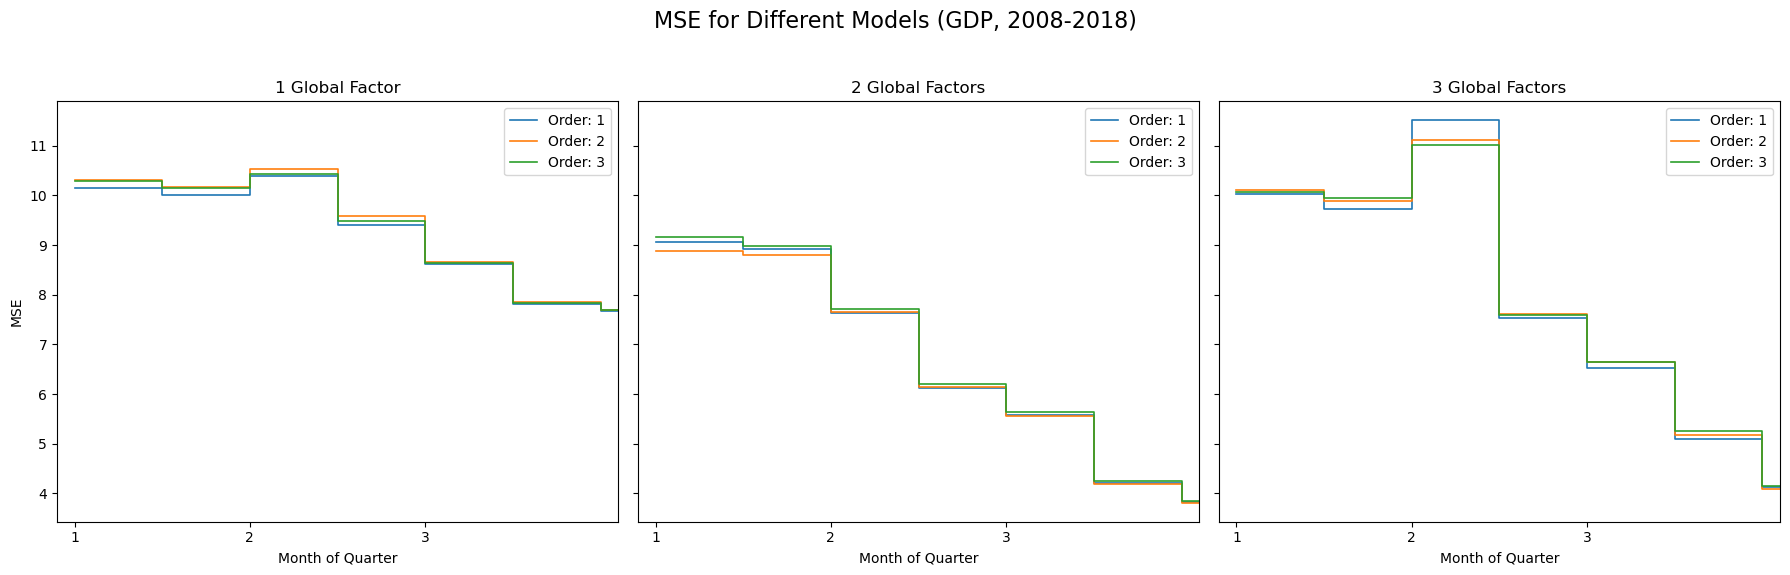

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'  

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


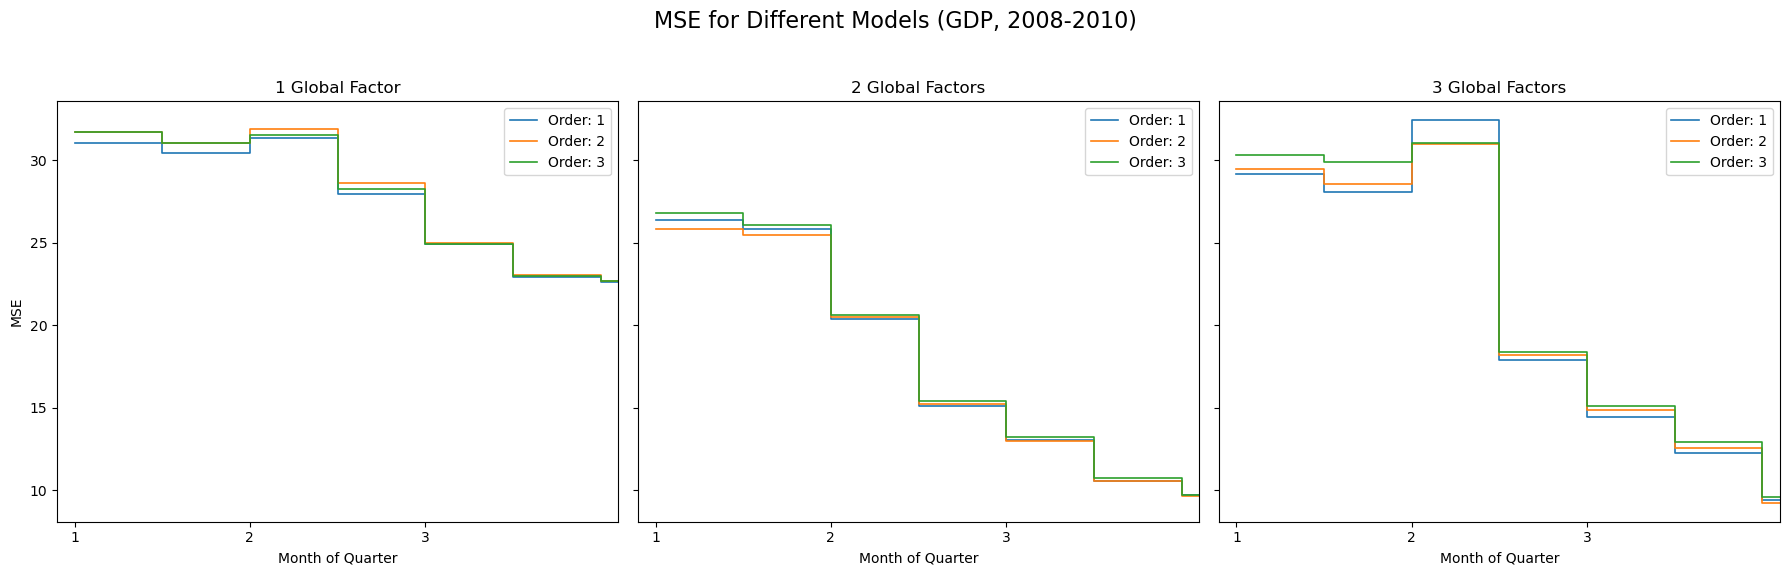

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


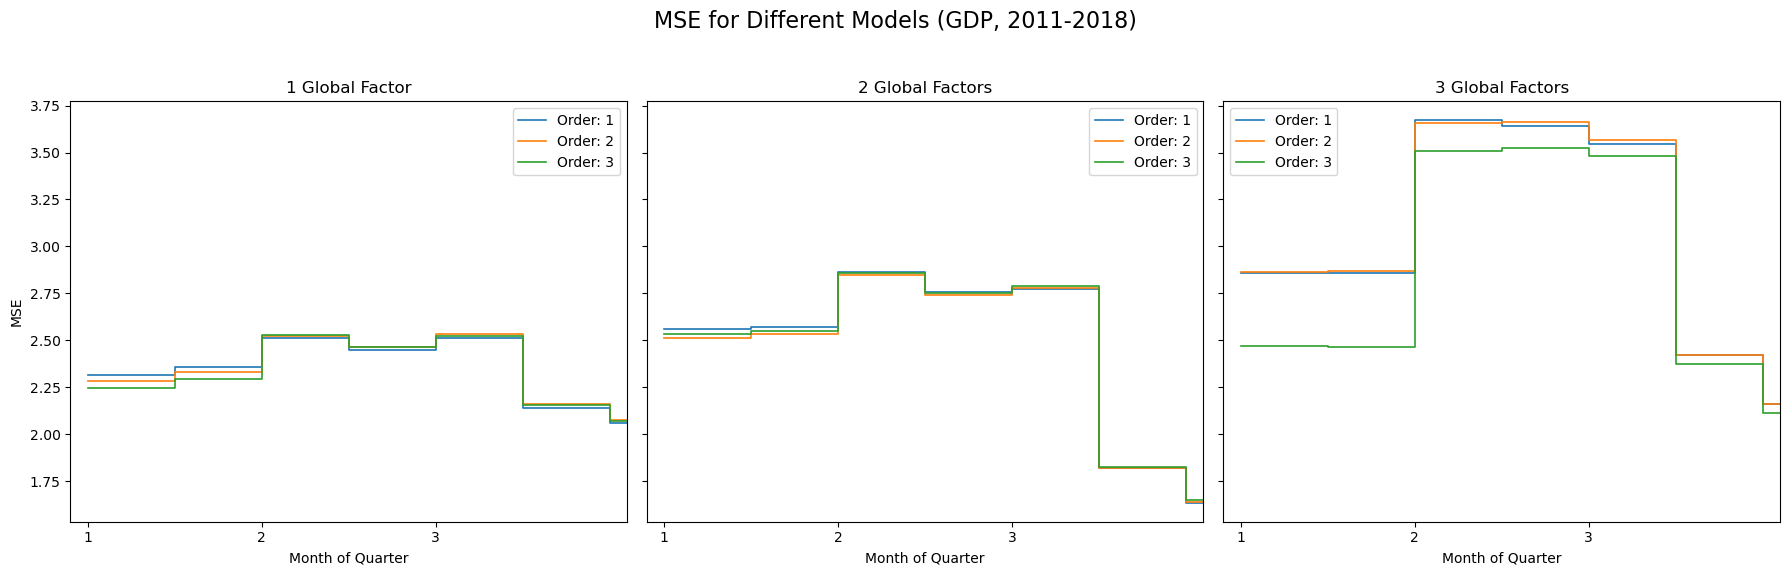

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


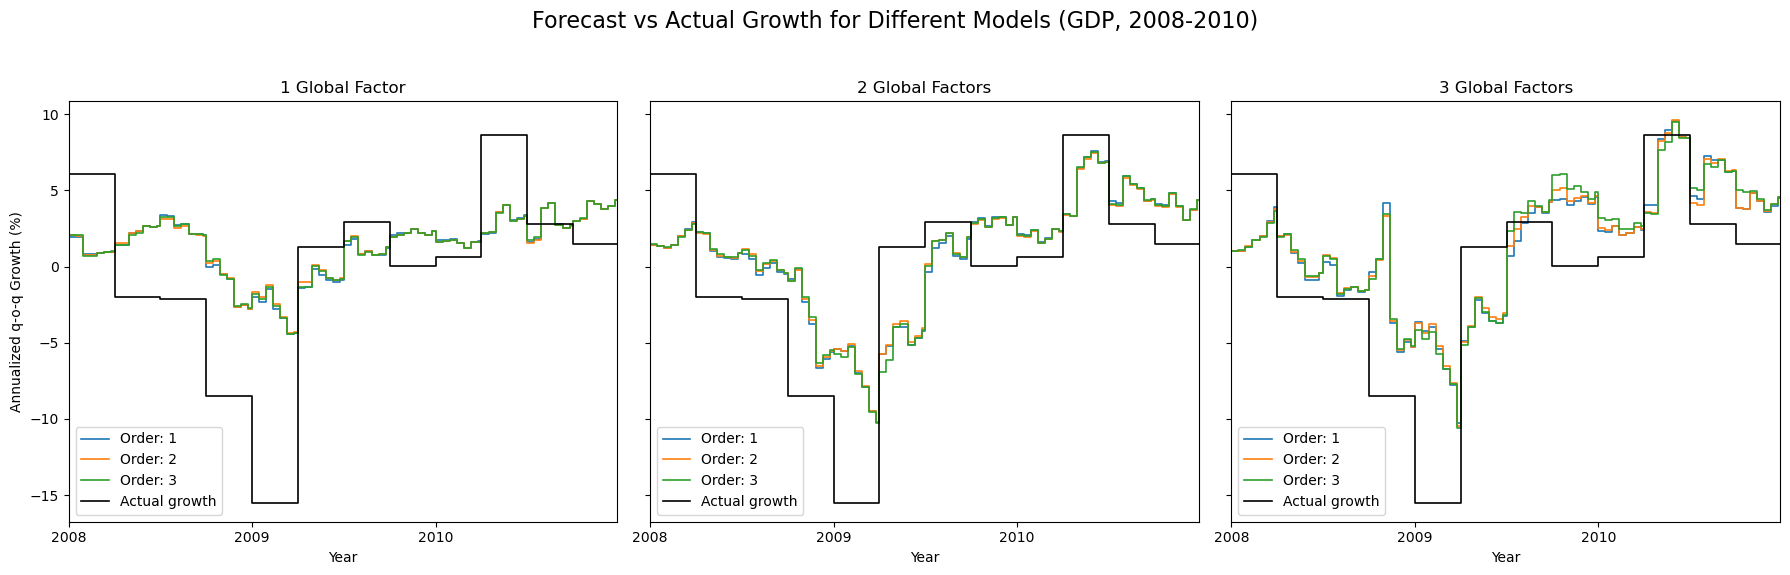

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


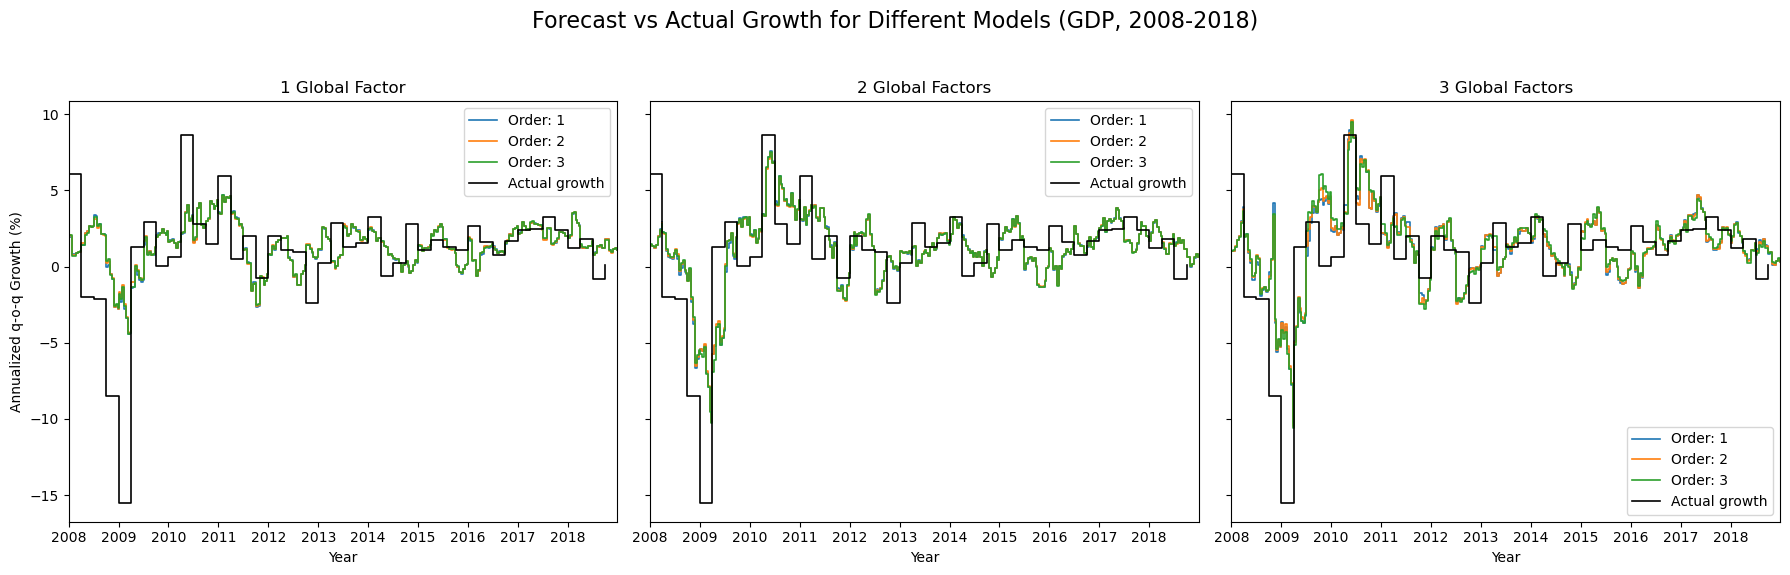

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


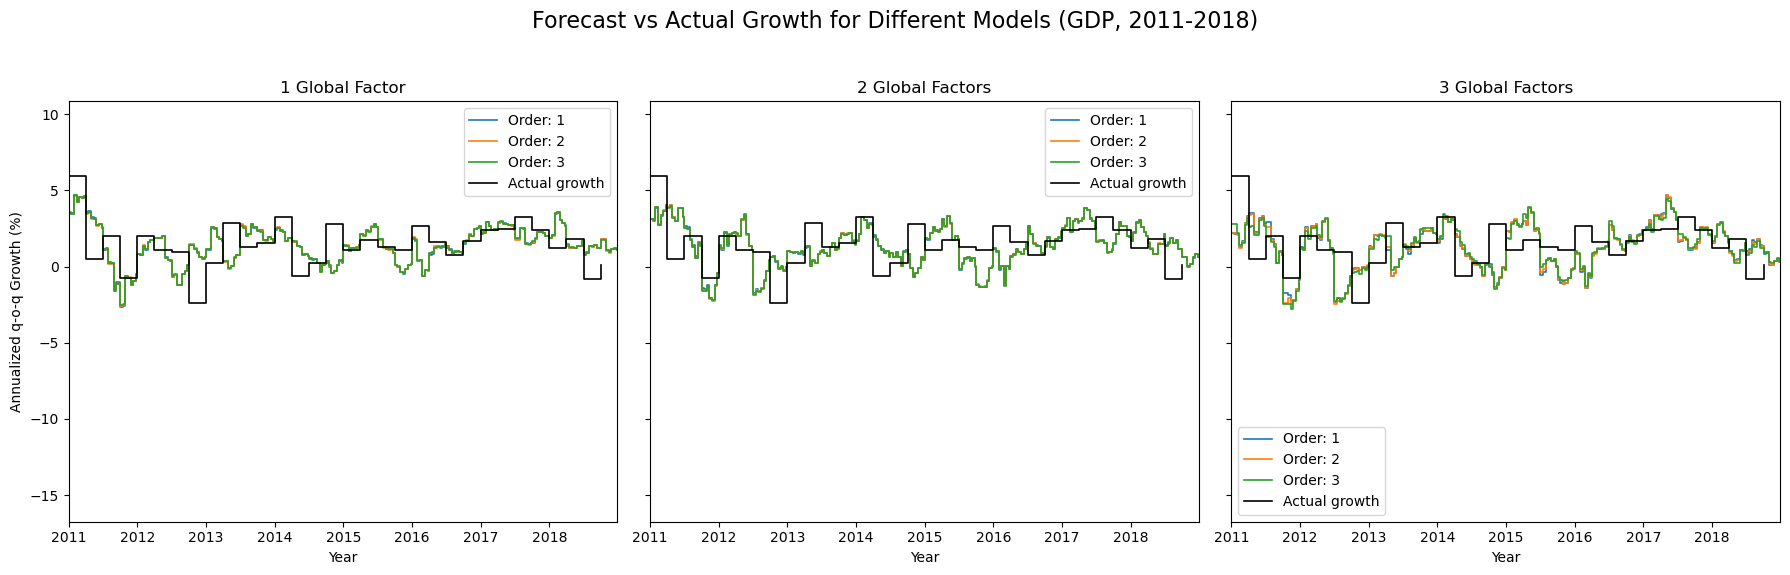

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act, y_act, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()